In [1]:
%matplotlib inline

import pandas as pd
import pymc3 as pm
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from scipy import stats
import numpy as np

plt.style.use('seaborn-whitegrid')

In [2]:
def summarize(alpha=0.05):
    
    def _summarize(ser):
        hpd_ = pm.hpd(ser, alpha=alpha)
        return pd.Series({
            'mean_': ser.mean(),
            'lower': hpd_[0],
            'upper': hpd_[1],
        })
    
    return _summarize


def agg_prediction(trace_var, source_data, group_columns, aggregate_fc):
    df = pd.DataFrame(trace_var).stack().reset_index()
    merged = pd.merge(
        df, source_data,
        left_on='level_1', right_index=True
    )

    return (
        merged.groupby(group_columns)[0].apply(aggregate_fc)
        .unstack().sort_index().reset_index()
    )


In [3]:
howell1 = pd.read_csv('../data/Howell1.csv', sep=';')
howell1.head()

,height,weight,age,male
0,151.765,47.825606,63.0,1
1,139.700,36.485807,63.0,0
2,136.525,31.864838,65.0,0
3,156.845,53.041915,41.0,1
4,145.415,41.276872,51.0,0


**H1** The weights listed below were recorded in the `!Kung` census, but heights were not recorded for these individuals. Provide predicted heights and 89% intervals (either HPDI or PI) for each of these individuals. That is, fill in the table below, using model-based predictions.

Individual,  weight,  expected height,  89% interval 

weight:
``` 
  46.95,
  43.72,
  64.78,
  32.59,
  54.63
```

In [4]:
weight_missing = pd.Series([46.95, 43.72, 64.78, 32.59, 54.63], name='weight_test')

In [5]:
with pm.Model() as model_4h1:
    alpha = pm.Lognormal('alpha', mu=np.log(howell1.height.mean()), sd=20)
    beta = pm.Normal('beta', mu=0, sd=100)

    w_scaled = (howell1.weight.values - howell1.weight.mean()) / howell1.weight.std()
    
    height = pm.Deterministic(
        'height',
        alpha + beta * w_scaled
    )

    sigma = pm.HalfCauchy('sigma', beta=10)
    height_obs = pm.Normal(
        'height_obs',
        mu=height, sd=sigma,
        observed=howell1.height.values
    )
    
    height_missing = pm.Deterministic(
        'height_missing',
        alpha + beta * (weight_missing.values - howell1.weight.mean()) / howell1.weight.std()
    )

    model_4h1.trace = pm.sample(5000, tune=1000, chains=2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, beta, alpha]
Sampling 2 chains: 100%|██████████| 12000/12000 [00:09<00:00, 1283.02draws/s]


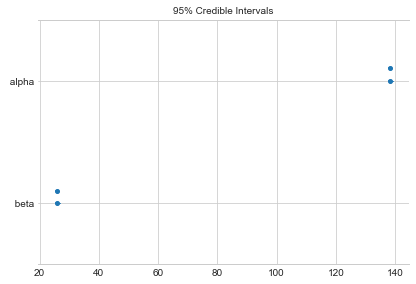

In [6]:
pm.forestplot(model_4h1.trace, varnames=['alpha', 'beta'], rhat=False)
None

In [7]:
height_missing = agg_prediction(
    model_4h1.trace['height_missing'],
    weight_missing.to_frame(),
    ['weight_test'], summarize(.11)
)
height_missing

,weight_test,mean_,lower,upper
0,32.59,132.932649,132.280314,133.605443
1,43.72,152.566726,151.838847,153.310683
2,46.95,158.264666,157.447730,159.067402
3,54.63,171.812708,170.706019,172.804167
4,64.78,189.717998,188.281206,191.128268


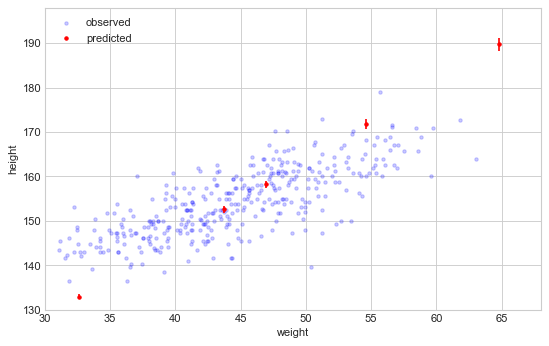

In [10]:
err = np.array([
    - height_missing.lower + height_missing.mean_,
    height_missing.upper - height_missing.mean_])

fig, ax = plt.subplots(1, 1, figsize=(8, 5), dpi=80)

ax.scatter(howell1.weight, howell1.height,
           marker='.', alpha=.2, color='b', label='observed')
ax.scatter(height_missing['weight_test'], height_missing.mean_,
           marker='.', alpha=1, color='r', label='predicted')
ax.errorbar(height_missing['weight_test'], height_missing.mean_,
            linestyle='', yerr=err, color='r', label='')
ax.legend()
ax.set(xlabel='weight', ylabel='height',
       xlim=(30, None), ylim=(130, None))
None

**H2**. Select out all the rows in the Howell1 data with ages below 18 years of age. If you do it right,
you should end up with a new data frame with 192 rows in it.

In [11]:
howell1_18 = howell1[howell1.age < 18]
howell1_18 = howell1_18.reset_index(drop=True)
howell1_18.shape[0]

192

(a) Fit a linear regression to these data, using map. Present and interpret the estimates. For every
10 units of increase in weight, how much taller does the model predict a child gets?

In [12]:
with pm.Model() as model_4H2_a:
    alpha = pm.Lognormal('alpha', mu=np.log(howell1_18.height.mean()), sd=20)
    beta = pm.Normal('beta', mu=0, sd=100)

    w_scaled = (howell1_18.weight.values - howell1_18.weight.mean()) / howell1_18.weight.std()
    
    _mu_height = alpha + beta * (howell1_18.weight - howell1_18.weight.mean())
    height = pm.Deterministic(
        'height',
        alpha + beta * w_scaled
    )

    sigma = pm.HalfCauchy('sigma', beta=10)
    height_obs = pm.Normal(
        'height_obs', mu=height, sd=sigma,
        observed=howell1_18.height.values
    )

    start = pm.find_MAP()

/home/petrushev/etc/jup_env/lib/python3.7/site-packages/pymc3/tuning/starting.py:61: UserWarning: find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.
  warnings.warn('find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.')
logp = -710.74, ||grad|| = 596.23: 100%|██████████| 30/30 [00:00<00:00, 945.15it/s]  


In [13]:
np.asscalar(start['beta'])

24.314831470401895

(b) Plot the raw data, with height on the vertical axis and weight on the horizontal axis. Superimpose the MAP regression line and 89% HPDI for the mean. Also superimpose the 89% HPDI for
predicted heights.

In [14]:
with model_4H2_a:
    model_4H2_a.trace = pm.sample(5000, tune=1000, chains=2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, beta, alpha]
Sampling 2 chains: 100%|██████████| 12000/12000 [00:09<00:00, 1296.32draws/s]


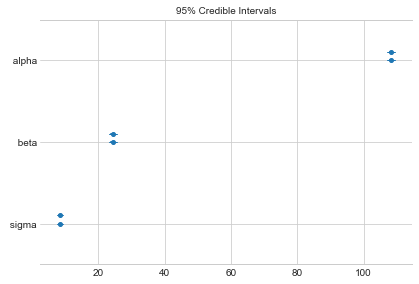

In [15]:
pm.forestplot(model_4H2_a.trace, varnames=['alpha', 'beta', 'sigma'], rhat=False)
None

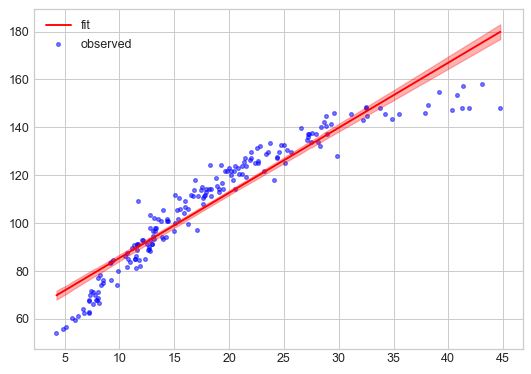

In [16]:
height = agg_prediction(model_4H2_a.trace['height'], howell1_18,
                        ['weight'], summarize(.11))

fig, ax = plt.subplots(1, 1, figsize=(7, 5), dpi=90)

ax.scatter(howell1_18.weight, howell1_18.height,
           color='b', alpha=.5, label='observed', marker='.')
ax.plot(height.weight, height.mean_,
        color='r', label='fit')
ax.fill_between(height.weight, height.lower, height.upper,
                color='r', alpha=.3)

ax.legend()
None

(c) What aspects of the model fit concern you? Describe the kinds of assumptions you would
change, if any, to improve the model. You don’t have to write any new code. Just explain what the
model appears to be doing a bad job of, and what you hypothesize would be a better model.

piecewise linear model with **switchpoint**

In [17]:
with pm.Model() as model_4H2_c_piecewise:
    alpha = pm.Lognormal('alpha', mu=np.log(120), sd=20)
    beta = pm.Normal('beta', mu=0, sd=10, shape=2)

    resolution = 3
    _switchpoint = pm.DiscreteUniform(
        '_switchpoint',
        lower=15 * resolution, upper=25 * resolution)
    switchpoint = pm.Deterministic('switchpoint', _switchpoint / resolution)

    condition = pm.math.le(switchpoint, howell1_18.weight)
    _beta = pm.math.switch(condition, beta[0], beta[1])

    height = pm.Deterministic(
        'height',
        alpha + _beta * (howell1_18.weight.values - switchpoint)
    )

    sigma = pm.HalfCauchy('sigma', beta=10)
    height_obs = pm.Normal('height_obs', mu=height, sd=sigma,
                           observed=howell1_18.height)

    model_4H2_c_piecewise.trace = pm.sample(10000, tune=1000, chains=2)

Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>NUTS: [sigma, beta, alpha]
>Metropolis: [_switchpoint]
Sampling 2 chains: 100%|██████████| 22000/22000 [00:37<00:00, 374.42draws/s]
The estimated number of effective samples is smaller than 200 for some parameters.


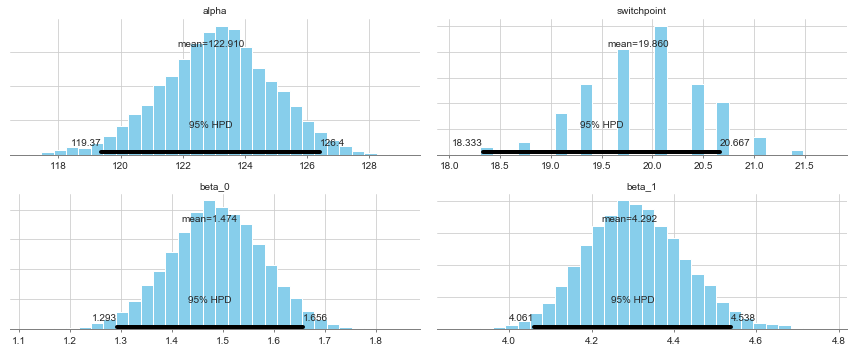

In [19]:
pm.plot_posterior(model_4H2_c_piecewise.trace, varnames=['alpha', 'switchpoint', 'beta'])
None

In [24]:
height = agg_prediction(model_4H2_c_piecewise.trace['height'], howell1_18,
                        ['weight'], summarize(.11))

switchpoint = agg_prediction(model_4H2_c_piecewise.trace['switchpoint'], howell1_18,
                             ['weight'], summarize(.11))


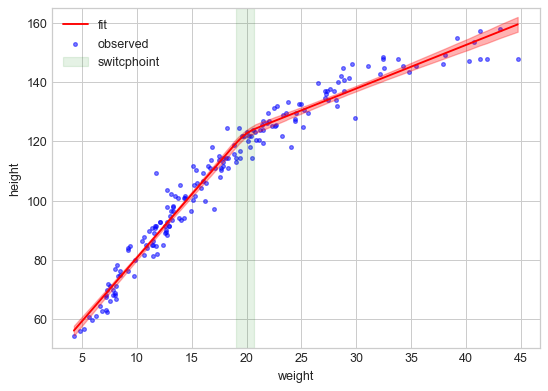

In [34]:
fig, ax = plt.subplots(1, 1, figsize=(7, 5), dpi=90)

ax.scatter(howell1_18.weight, howell1_18.height,
           color='b', alpha=.5, label='observed', marker='.')
ax.plot(height.weight, height.mean_,
        color='r', label='fit')
ax.fill_between(height.weight, height.lower, height.upper,
                color='r', alpha=.3)

ax.fill_betweenx([50, 165], switchpoint.lower, switchpoint.upper,
                 alpha=.1, label='switcphoint', color='green')

ax.set(xlabel='weight', ylabel='height',
       ylim=(50, 165))

ax.legend()
None

**H3**. Suppose a colleague of yours, who works on allometry, glances at the practice problems just
above. Your colleague exclaims, “That’s silly. Everyone knows that it’s only the logarithm of body
weight that scales with height!” Let’s take your colleague’s advice and see what happens.

(a) Model the relationship between height (cm) and the natural logarithm of weight (log-kg). Use
the entire `Howell1` data frame, all 544 rows, adults and non-adults. Fit this model, using quadratic
approximation:

```
hi ∼ Normal(μi, σ)

μi = α + β log(wi)

α ∼ Normal(178, 100)

β ∼ Normal(0, 100)

σ ∼ Uniform(0, 50)
```

where hi is the height of individual i and wi is the weight (in kg) of individual i. Can you interpret the resulting estimates?

In [35]:
with pm.Model() as model_4h3:
    alpha = pm.Normal('alpha', mu=178, sd=100)
    beta = pm.Normal('beta', mu=0, sd=100)

    height = pm.Deterministic(
        'height',
        alpha + beta * np.log(howell1.weight.values))

    sigma = pm.HalfCauchy('sigma', beta=10)
    height_obs = pm.Normal('height_obs', mu=height, sd=sigma,
                           observed=howell1.height)
    model_4h3.trace = pm.sample(5000, tune=1000, chains=2)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, beta, alpha]
Sampling 2 chains: 100%|██████████| 12000/12000 [00:31<00:00, 386.49draws/s]
The acceptance probability does not match the target. It is 0.8824337572956237, but should be close to 0.8. Try to increase the number of tuning steps.


(b) Begin with this plot:
```
plot( height ~ weight , data=Howell1 , col=col.alpha(rangi2,0.4) )
```
Then use samples from the quadratic approximate posterior of the model in (a) to superimpose on
the plot: (1) the predicted mean height as a function of weight, (2) the 97% HPDI for the mean, and
(3) the 97% HPDI for predicted heights.


In [37]:
with model_4h3:
    ppc = pm.sample_posterior_predictive(model_4h3.trace, vars=[height_obs], samples=10000)

100%|██████████| 10000/10000 [00:07<00:00, 1303.97it/s]


In [38]:
height = agg_prediction(model_4h3.trace['height'], howell1,
                        ['weight'], summarize(0.03))

In [40]:
height_ppc = agg_prediction(ppc['height_obs'], howell1,
                            ['weight'], summarize(0.03))

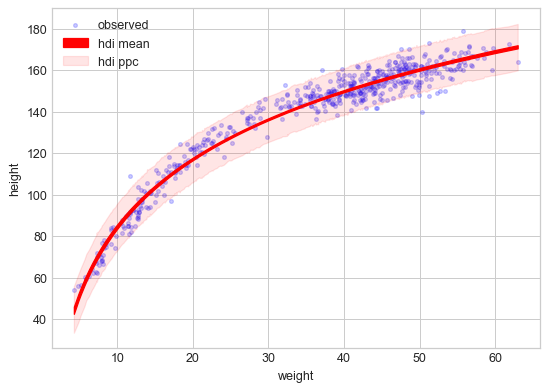

In [45]:
fig, ax = plt.subplots(1, 1, figsize=(7, 5), dpi=90)

ax.scatter(howell1.weight, howell1.height,
           color='b', alpha=.2, label='observed', marker='.')
ax.fill_between(height.weight, height.lower, height.upper,
                color='r', alpha=.99, label='hdi mean')
ax.fill_between(height_ppc.weight, height_ppc.lower, height_ppc.upper,
                color='r', alpha=.1, label='hdi ppc')

ax.set(xlabel='weight', ylabel='height')
ax.legend()
None